# Ghana COVID-19 — Exploratory Data Analysis
This notebook provides quick EDA steps for the Ghana COVID-19 dataset.
Run the cells to load the processed timeseries, visualize trends, and inspect supervised train/test datasets used for modeling.

In [7]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
sns.set(style="whitegrid")

In [8]:
from pathlib import Path
import pandas as pd

# show current working directory (helps debug)
from os import getcwd
print("Notebook CWD:", getcwd())

# build a resolved path relative to project root (adjust if needed)
# if your notebook server is started from the project root, this will point to the correct file
ts_path = Path("data") / "processed" / "cases_timeseries.csv"
print("Looking for:", ts_path, "-> exists?", ts_path.exists())

# If it doesn't exist, try resolving upward one level (common if notebook server started in notebooks/)
if not ts_path.exists():
    ts_path = Path("..") / "data" / "processed" / "cases_timeseries.csv"
    print("Trying parent path:", ts_path, "-> exists?", ts_path.exists())

# final check
if not ts_path.exists():
    raise FileNotFoundError(f"Could not find timeseries at {ts_path}. Make sure you've run src/preprocess.py and started the notebook from the project root.")

ts = pd.read_csv(ts_path, parse_dates=['date'], index_col='date')
ts.head()

Notebook CWD: /Users/theboybrey/dev/workspace/jarvis/notebooks
Looking for: data/processed/cases_timeseries.csv -> exists? False
Trying parent path: ../data/processed/cases_timeseries.csv -> exists? True


,daily_cases,cumulative_cases
date,,
2020-06-18,304.0,304.0
2020-06-19,85.0,389.0
2020-06-20,279.0,668.0
2020-06-21,116.0,784.0
2020-06-22,399.0,1183.0


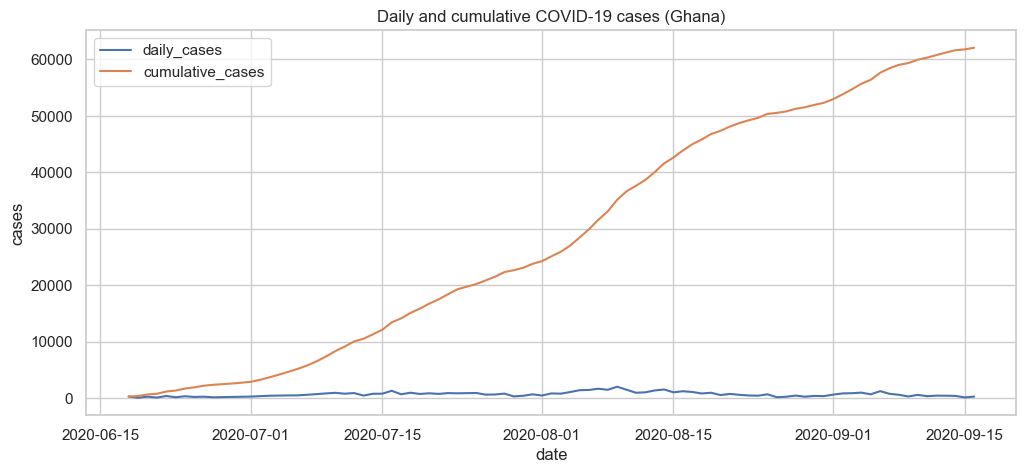

In [9]:
# Plot daily and cumulative cases
plt.figure(figsize=(12,5))
plt.plot(ts.index, ts['daily_cases'], label='daily_cases')
plt.plot(ts.index, ts['cumulative_cases'], label='cumulative_cases')
plt.legend()
plt.title('Daily and cumulative COVID-19 cases (Ghana)')
plt.xlabel('date')
plt.ylabel('cases')
plt.show()

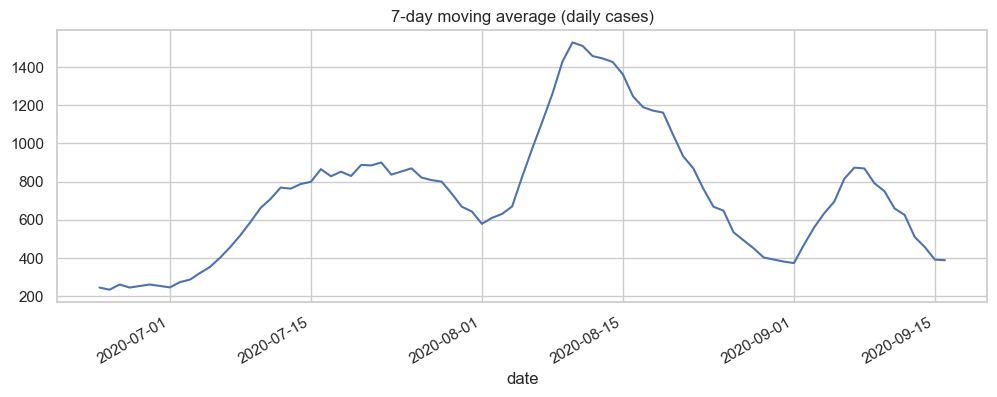

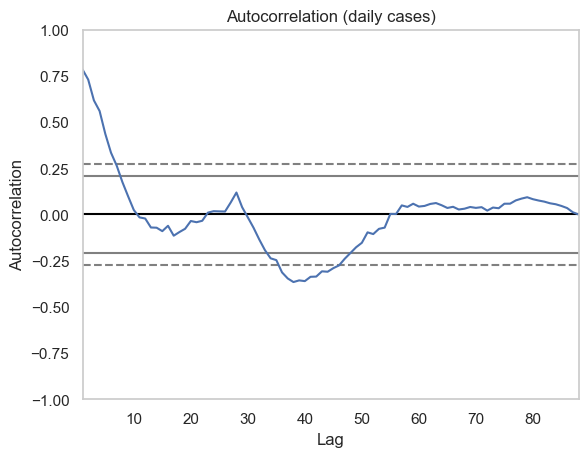

In [10]:
# Rolling averages and autocorrelation
ts['daily_cases'].rolling(7).mean().plot(figsize=(12,4), label='7-day MA')
plt.title('7-day moving average (daily cases)')
plt.show()
autocorrelation_plot(ts['daily_cases'].dropna())
plt.title('Autocorrelation (daily cases)')
plt.show()

In [11]:
# Inspect supervised train/test created for modeling
from pathlib import Path
# robustly locate train/test relative to project root or notebook folder
train_path = Path('data') / 'processed' / 'train.csv'
test_path = Path('data') / 'processed' / 'test.csv'
if not train_path.exists():
    train_path = Path('..') / 'data' / 'processed' / 'train.csv'
    test_path = Path('..') / 'data' / 'processed' / 'test.csv'
print('Looking for train at', train_path, '->', train_path.exists())
if not train_path.exists():
    raise FileNotFoundError(f'Could not find train.csv at {train_path}. Run src/train_model.py to create it.')
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
print('Train shape:', train.shape)
print('Test shape:', test.shape)
train.head()

Looking for train at ../data/processed/train.csv -> True
Train shape: (59, 20)
Test shape: (14, 20)


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,roll_mean_7,roll_std_7,roll_mean_14,roll_std_14,pct_change_1,target
0,444.0,368.0,293.0,228.0,168.0,275.0,226.0,351.0,175.0,399.0,116.0,279.0,85.0,304.0,286.000000,93.760333,265.071429,105.831117,0.206522,500.0
1,470.0,444.0,368.0,293.0,228.0,168.0,275.0,226.0,351.0,175.0,399.0,116.0,279.0,85.0,320.857143,111.427747,276.928571,119.007087,0.058559,510.0
2,500.0,470.0,444.0,368.0,293.0,228.0,168.0,275.0,226.0,351.0,175.0,399.0,116.0,279.0,353.000000,127.314571,306.571429,119.208101,0.063830,614.0
3,510.0,500.0,470.0,444.0,368.0,293.0,228.0,168.0,275.0,226.0,351.0,175.0,399.0,116.0,401.857143,108.757266,323.071429,130.545874,0.020000,725.0
4,614.0,510.0,500.0,470.0,444.0,368.0,293.0,228.0,168.0,275.0,226.0,351.0,175.0,399.0,457.000000,103.651660,358.642857,137.447952,0.203922,851.0


## Next steps
- Run `python src/train_model.py` to (re)train models. The best RF model is saved to `models/rf_best.joblib`.
- Evaluate the saved model using `src/evaluate.evaluate_regression` or run the evaluation cell below to produce plots saved in `reports/figures/`.
- Use this notebook to add more EDA cells (region breakdown, feature correlations, model diagnostics).

In [13]:
# Quick evaluation cell: loads the saved RF and plots predictions vs actual (requires models/rf_best.joblib)
import sys, pathlib
# Ensure project root (contains 'src') is on sys.path so 'from src import ...' works
p = pathlib.Path().resolve()
if (p / 'src').exists():
    root = p
elif (p.parent / 'src').exists():
    root = p.parent
else:
    raise RuntimeError('Could not locate project root with src/ directory; start notebook from project root or adjust paths')
sys.path.insert(0, str(root))
try:
    from joblib import load
    from src.evaluate import evaluate_regression
    model = load(str(root / 'models' / 'rf_best.joblib'))
    df = pd.read_csv(str(root / 'data' / 'processed' / 'test.csv'))
    X_test = df.drop(columns=['target'])
    y_test = df['target']
    print(evaluate_regression(model, X_test, y_test, model_name='rf_best'))
except Exception as e:
    print('Could not run evaluation cell:', e)

Could not run evaluation cell: got an unexpected keyword argument 'squared'
